In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the datasets
de_train = pd.read_parquet('data/de_train.parquet')
# adata_train = pd.read_parquet('data/adata_train.parquet')
# adata_obs_meta = pd.read_csv('data/adata_obs_meta.csv')
# multiome_train = pd.read_parquet('data/multiome_train.parquet')
# multiome_obs_meta = pd.read_csv('data/multiome_obs_meta.csv')
# multiome_var_meta = pd.read_csv('data/multiome_var_meta.csv')
# id_map = pd.read_csv('data/id_map.csv')
# sample_submission = pd.read_csv('data/sample_submission.csv')

# Print the head of each dataset for a quick check
display(de_train.head())
# display(adata_train.head())
# display(adata_obs_meta.head())
# display(multiome_train.head())
# display(multiome_obs_meta.head())
# display(multiome_var_meta.head())
# display(id_map.head())
# display(sample_submission.head())


,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [2]:
# Data exploration and visualization
# Checking for missing values
missing_values = de_train.isnull().sum().sort_values(ascending=False)
print("Missing values in each column:\n", missing_values[missing_values > 0])

# Check the number of unique values in 'cell_type' and 'sm_name'
unique_cell_types = de_train['cell_type'].nunique()
unique_sm_names = de_train['sm_name'].nunique()
print(f'Unique cell types: {unique_cell_types}, Unique sm_names: {unique_sm_names}')


Missing values in each column:
 Series([], dtype: int64)
Unique cell types: 6, Unique sm_names: 146


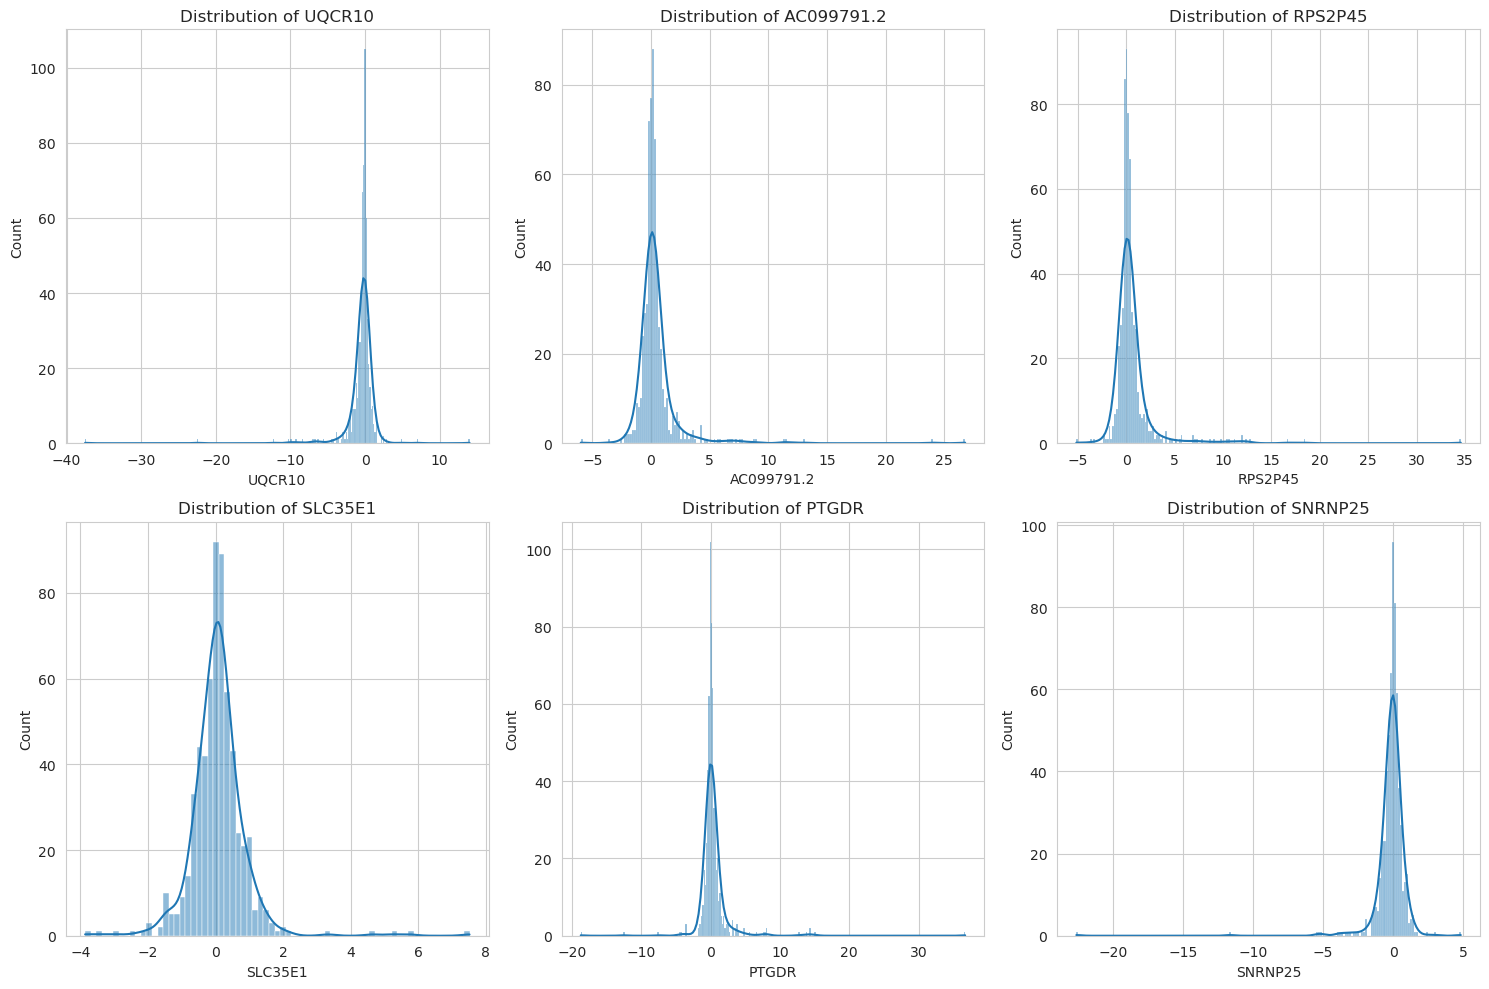

In [3]:
# Visualize the distribution of a few genes
sns.set_style("whitegrid")
random_genes = np.random.choice(de_train.columns[5:], 6, replace=False)
plt.figure(figsize=(15, 10))
for i, gene in enumerate(random_genes, 1):
    plt.subplot(2, 3, i)
    sns.histplot(de_train[gene], kde=True)
    plt.title(f'Distribution of {gene}')
plt.tight_layout()
plt.show()

In [ ]:
# Preprocessing
# One-hot encode categorical variables
de_train_encoded = pd.get_dummies(de_train, columns=['cell_type', 'sm_name'])

# Scale the gene expression data
scaler = MinMaxScaler()
gene_expression_columns = de_train_encoded.columns[5:].tolist()
de_train_encoded[gene_expression_columns] = scaler.fit_transform(de_train_encoded[gene_expression_columns])

# Prepare for modeling
# For demonstration, let's predict the differential expression for one gene
target_gene = gene_expression_columns[0]
X = de_train_encoded.drop(columns=['sm_lincs_id', 'SMILES', 'control'] + gene_expression_columns)
y = de_train_encoded[target_gene]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Uncomment below lines to run the model training and evaluation
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

# Prepare the submission file
predictions = xgb_model.predict(...)  # Replace with the actual prediction code
sample_submission.loc[:, gene_expression_columns] = predictions
sample_submission.to_csv('data/my_submission.csv', index=False)